# `vaex` @ PyData Budapest 2020

## New York Taxi Dataset (2009-2015): Exploratory Data Analysis

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page


Running this notebooks requires `vaex==3.0.0`

In [1]:
import vaex
from vaex.ui.colormaps import cm_plusmin

import numpy as np

import pylab as plt
import seaborn as sns

import pandas as pd
pd.options.display.max_rows = 70

import warnings; warnings.simplefilter('ignore')

### Main concepts behind `vaex`:
 - Memory mapping
 - Lazy evaluations
 - Expression system ("virtual" columns)
 - High-performance algorithms

### Memory mapping

In [2]:
!du -h /data/yellow*

164G	/data/yellow_taxi_2009_2015.hdf5
108G	/data/yellow_taxi_2009_2015_f32.hdf5
12G	/data/yellow_taxi_2015_f32.hdf5


Get instant access to your data!

In [10]:
df = vaex.open('/data/yellow_taxi_2009_2015_f32.hdf5')

You can also stream it directly from S3:
```
df = vaex.open('s3://vaex/taxi/yellow_taxi_2015_f32s.hdf5?anon=true')
```

### Lazy evaluations

Just get a quick preview whenever you want to "peak" at your data

In [13]:
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.350000381469727,-74.0025863647461,40.73974609375,nan,nan,-73.86997985839844,40.770225524902344,23.700000762939453,0.0,nan,4.739999771118164,0.0,28.440000534057617
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863


### Expression system ("virtual" columns)

We call a single "column" an "expression"

In [14]:
df.tip_amount

Expression = tip_amount
Length: 1,173,057,927 dtype: float32 (column)
---------------------------------------------
         0     0
         1     2
         2  4.74
         3  3.05
         4     0
      ...       
1173057922  1.76
1173057923     0
1173057924     0
1173057925     0
1173057926  2.96

Defining new columns takes no memory

In [15]:
df['tip_percentage'] = df.tip_amount / df.total_amount
df.tip_amount

Expression = tip_amount
Length: 1,173,057,927 dtype: float32 (column)
---------------------------------------------
         0     0
         1     2
         2  4.74
         3  3.05
         4     0
      ...       
1173057922  1.76
1173057923     0
1173057924     0
1173057925     0
1173057926  2.96

Peeking at the data is instant

In [16]:
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273,0.0
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727,0.13698630034923553
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.350000381469727,-74.0025863647461,40.73974609375,nan,nan,-73.86997985839844,40.770225524902344,23.700000762939453,0.0,nan,4.739999771118164,0.0,28.440000534057617,0.1666666567325592
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453,0.16531164944171906
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167,0.1666666567325592
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863,0.0
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863,0.0
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863,0.0


Vaex knows when to be lazy, and when to be eager:
 - If the output of an operation is a new column, vaex will be lazy
 - If the output of an operation is expected to be a new data strugture (single number, list etc..), vaex will be eager

In [17]:
df.tip_percentage.mean()

array(inf)

Filtering creates a shallow copy of the DataFrame. The data itself is not copied!

In [18]:
df_filtered = df[df.total_amount>0]

In [19]:
df_filtered.tip_percentage.mean()

array(0.07121788)

### High performance, efficient algorithms

In [20]:
# Check length of file
rows, columns = df.shape
print(f'Number of rows: {rows:,}')
print(f'Number of columns: {columns}')

Number of rows: 1,173,057,927
Number of columns: 19


In [21]:
df.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage
dtype,str,datetime64[ns],datetime64[ns],int64,str,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
count,1173057927,1173057927,1173057927,1173057927,1173057927,1173057927,1173057927,1173057926,1002161871,638914438,1173043432,1173050240,1173057925,1173057925,1032017356,1173057925,1173057925,1173057925,1173034681
NA,0,0,0,0,0,0,0,1,170896056,534143489,14495,7687,2,2,141040571,2,2,2,23246
mean,--,1970-01-01T00:00:01.953533625,1970-01-01T00:00:14.506598422,1.6844313554517245,--,5.390923660999704,-72.53224844702991,39.9345313935188,1.035820754150404,0.017168377090266976,-72.53741806425096,39.93694872311038,11.217308155801057,0.3036385232379655,0.4963069205116383,1.1294571893027419,0.1867806751775823,13.314765814201305,inf
std,--,6.22239e+16,6.22266e+16,1.33032,--,7756.52,12.7505,9.51675,0.441996,0.129899,12.6768,9.50487,633.505,0.395407,0.0683994,132.842,886.718,1098.43,NaN
min,--,2009-01-01T00:00:27.365015552,1899-12-31T23:59:43.370698752,0,--,-4.08401e+07,-3509.02,-3579.14,0,0,-3579.14,-3579.14,-2.14748e+07,-79,-3,-1.67772e+06,-2.14748e+07,-2.14748e+07,-0.0877193
max,--,2016-01-01T00:00:49.632313344,2253-08-23T08:00:13.061652480,255,--,1.98623e+08,3570.22,3577.14,252,2,3460.43,3577.14,825999,999.99,1311.22,3.95059e+06,5510.07,3.95061e+06,inf


## Application: Exploring and cleaning the New York Taxi dataset

### Remove missing data

In [22]:
# Drop NANs
df = df.dropna(column_names=['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude'])

### Abnormal number of passengers

In [27]:
df.passenger_count.value_counts(progress='widget')

1      812315955
2      172863547
5       81923905
3       51435661
6       25614703
4       24983364
0        3903564
208         1515
7            435
9            352
8            313
49            26
10            17
255           10
129            7
213            4
250            3
65             3
15             2
58             2
33             2
169            1
37             1
36             1
34             1
25             1
19             1
17             1
193            1
13             1
47             1
211            1
223            1
225            1
229            1
232            1
247            1
249            1
38             1
51             1
177            1
165            1
164            1
163            1
160            1
158            1
155            1
141            1
137            1
134            1
133            1
125            1
113            1
97             1
91             1
84             1
254            1
69             1
66            

In [28]:
# Filter abnormal number of passengers
df = df[(df.passenger_count>0) & (df.passenger_count<7)]

### Clean up distance values

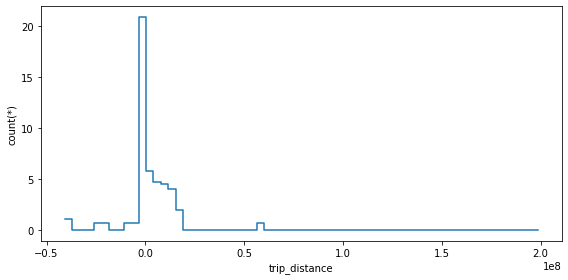

In [29]:
plt.figure(figsize=(8,4))
df.plot1d('trip_distance', limits='minmax', f='log1p', progress='widget')
plt.show()

In [30]:
# How many trips have 0.0 distance?
(df.trip_distance==0).astype('int').sum()

array(7844544)

In [31]:
# What is the largest distance?
_ = df.trip_distance.max(progress='widget')
print()
print(f'The maximum trip distance in the data is {_} miles')
print()
print('This is %3.1f times larger than the distance between the Earth and the Moon!' % (_ / 238_900))
print('or')
print('This is %1.1f times the distance to Mars!' % (_ / 33_900_000))


The maximum trip distance in the data is 198623008.0 miles

This is 831.4 times larger than the distance between the Earth and the Moon!
or
This is 5.9 times the distance to Mars!


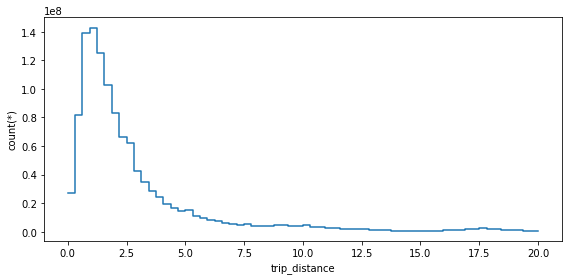

In [32]:
plt.figure(figsize=(8,4))
df.plot1d('trip_distance', limits=[0, 20], f=None, progress='widget')
plt.show()

In [33]:
# Filter negative and too large distances
df = df[(df.trip_distance>0) & (df.trip_distance<10)]

### What _is_ New York City really?

In [34]:
# Interactively plot the pickup locations
df.plot_widget(df.pickup_longitude, 
               df.pickup_latitude, 
               shape=512, 
               f='log1p', 
               colormap='plasma', 
               limits='minmax')

Heatmap(children=[ToolsToolbar(interact_value=None, supports_normalize=False, template='<template>\n  <v-toolb…

In [35]:
# Define the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Make a selection based on the boundaries
df = df[(df.pickup_longitude > long_min)  & (df.pickup_longitude < long_max) & \
        (df.pickup_latitude > lat_min)    & (df.pickup_latitude < lat_max) & \
        (df.dropoff_longitude > long_min) & (df.dropoff_longitude < long_max) & \
        (df.dropoff_latitude > lat_min)   & (df.dropoff_latitude < lat_max)]

### Create some date/time features

In [36]:
# Daily activities
df['pickup_hour'] = df.pickup_datetime.dt.hour
df['pickup_day_of_week'] = df.pickup_datetime.dt.dayofweek
df['pickup_is_weekend'] = (df.pickup_day_of_week>=5).astype('int')

# Treat as a categorical feature
df.categorize(column='pickup_hour', inplace=True)

weekday_names_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df.categorize(column='pickup_day_of_week', labels=weekday_names_list, inplace=True)
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,pickup_hour,pickup_day_of_week,pickup_is_weekend
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273,0.0,2,6,1
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727,0.13698630034923553,3,6,1
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453,0.16531164944171906,20,3,0
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716,0.0,16,5,1
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2000000476837158,-73.98980712890625,40.73500442504883,nan,nan,-73.98502349853516,40.72449493408203,6.099999904632568,0.5,nan,0.0,0.0,6.599999904632568,0.0,22,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,083,167,545",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167,0.1666666567325592,23,3,0
"1,083,167,546",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863,0.0,23,3,0
"1,083,167,547",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863,0.0,23,3,0
"1,083,167,548",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863,0.0,23,3,0


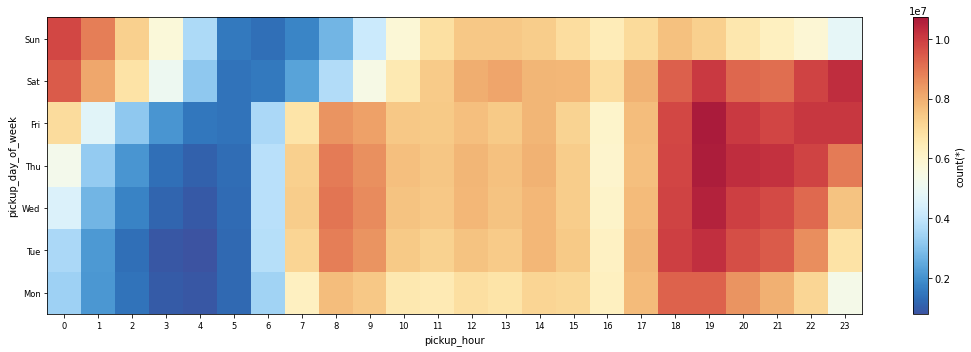

In [37]:
# Number of pick-ups per hour for a given day of the week
df.plot('pickup_hour', 'pickup_day_of_week', colorbar=True, colormap=cm_plusmin, figsize=(15, 5))

plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), weekday_names_list)
plt.show()

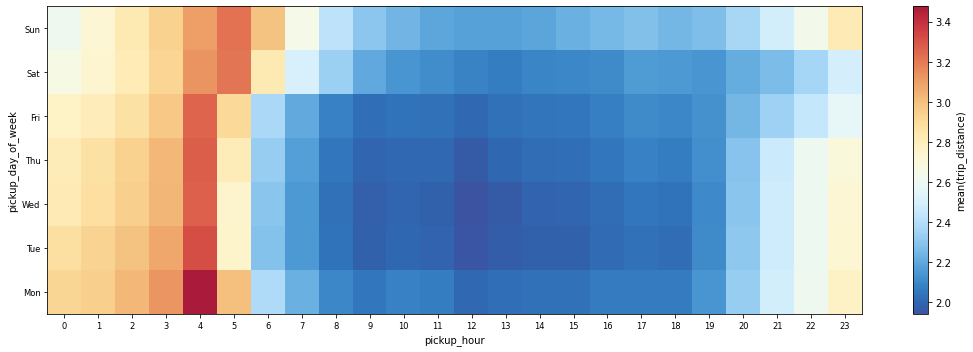

In [38]:
# Mean trip distance per hour for a given day of the week
df.plot('pickup_hour', 'pickup_day_of_week', what='mean(trip_distance)', 
        colorbar=True, colormap=cm_plusmin, figsize=(15, 5))

plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), weekday_names_list)
plt.show()

### Groupby examples

In [39]:
df_per_hour = df.groupby(by=df.pickup_hour).agg({'tip_amount': 'mean',
                                                 'tip_amount_weekend': vaex.agg.mean('tip_amount', 
                                                                                     selection='pickup_is_weekend==1')
                                                })

# Display the grouped DataFrame
df_per_hour

#,pickup_hour,tip_amount,tip_amount_weekend
0,0,1.0583148055719318,1.028166641654939
1,1,1.0395988285791358,1.0505457487273462
2,2,1.0271794254275997,1.0636084270722341
3,3,1.0004258190973754,1.050149848503694
4,4,0.9259400499895432,0.9313596322247085
...,...,...,...
19,19,1.0345855021860877,1.0917831661780708
20,20,1.0202804182400866,0.911085101443365
21,21,1.0258125215768232,0.8084636210998097
22,22,1.0711251054555473,0.9458610337789833


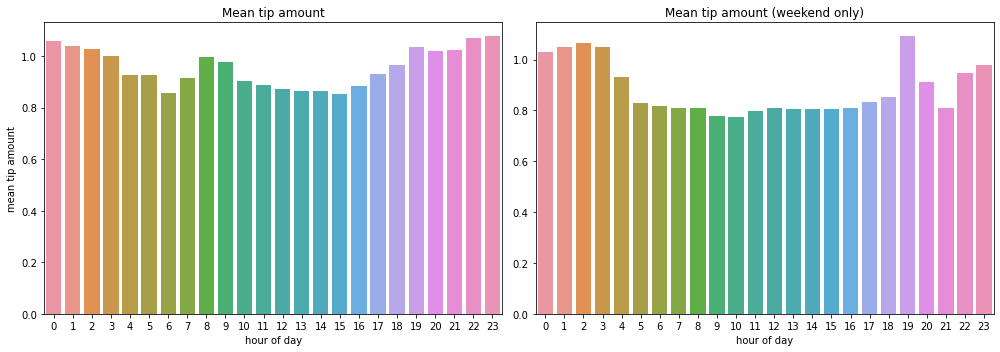

In [40]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
sns.barplot(x=df_per_hour.pickup_hour.values, y=df_per_hour.tip_amount.values)
plt.title('Mean tip amount')
plt.xlabel('hour of day')
plt.ylabel('mean tip amount')

plt.subplot(122)
sns.barplot(x=df_per_hour.pickup_hour.values, y=df_per_hour.tip_amount_weekend.values)
plt.title('Mean tip amount (weekend only)')
plt.xlabel('hour of day')
# plt.ylabel('mean trip speed [miles per hour]')


plt.tight_layout()
plt.show()

### Join

In [41]:
df = df.join(df_per_hour, on='pickup_hour', rprefix="right_")
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,pickup_hour,pickup_day_of_week,pickup_is_weekend,right_pickup_hour,right_tip_amount,tip_amount_weekend
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273,0.0,2,6,1,2,1.0271794254275997,1.0636084270722341
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727,0.13698630034923553,3,6,1,3,1.0004258190973754,1.050149848503694
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453,0.16531164944171906,20,3,0,20,1.0202804182400866,0.911085101443365
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716,0.0,16,5,1,16,0.8844376076193646,0.8114473797450418
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2000000476837158,-73.98980712890625,40.73500442504883,nan,nan,-73.98502349853516,40.72449493408203,6.099999904632568,0.5,nan,0.0,0.0,6.599999904632568,0.0,22,4,0,22,1.0711251054555473,0.9458610337789833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,083,167,545",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167,0.1666666567325592,23,3,0,23,1.077161833123374,0.9798870401138848
"1,083,167,546",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863,0.0,23,3,0,23,1.077161833123374,0.9798870401138848
"1,083,167,547",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863,0.0,23,3,0,23,1.077161833123374,0.9798870401138848
"1,083,167,548",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863,0.0,23,3,0,23,1.077161833123374,0.9798870401138848


### Expensive columns

Let's see the performance of Vaex on a computationally expensive virtual columns.

In [42]:
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# distance Budapest - Utrecht [miles]
arc_distance(47.4813602, 18.9902182, 52.0842715, 5.0124523)

698.4273037383392

By default we are using numpy

In [43]:
# Add the arc-distance in miles as a virtual column
df['arc_distance_miles_numpy'] = arc_distance(df.pickup_longitude, df.pickup_latitude, 
                                              df.dropoff_longitude, df.dropoff_latitude)

In [44]:
sum_numpy = df['arc_distance_miles_numpy'].sum(progress='widget')
print(f'{sum_numpy:.5}')

1.3943e+09


We can accelerate this by using Just-In-Time compiling (JIT)

In [45]:
df['arc_distance_miles_numba'] = df.arc_distance_miles_numpy.jit_numba()

In [46]:
sum_numba = df.arc_distance_miles_numba.sum(progress='widget')
print(f'{sum_numba:.5}')

1.3943e+09


Acceleration via a Nvidia GPU is also possible! This example uses _Nvidia 2080 super_.

In [47]:
df['arc_distance_miles_cuda'] = df.arc_distance_miles_numpy.jit_cuda()

In [48]:
sum_cuda = df.arc_distance_miles_cuda.sum(progress='widget')
print(f'{sum_cuda:.5}')

1.3943e+09


### For a fuller picture please check out [the tutorial on the documentation pages](https://docs.vaex.io/en/latest/tutorial.html).